In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from google.colab import drive

from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers, models
from tensorflow.keras.metrics import Precision, Recall

ModuleNotFoundError: No module named 'numpy'

In [ ]:
!pip install tensorflow

In [2]:
data_dir= '/content/drive/MyDrive/Task_A/train'
male_dir= '/content/drive/MyDrive/Task_A/train/male'
female_dir= '/content/drive/MyDrive/Task_A/train/female'

In [3]:
import random
import numpy as np
import shutil
import tempfile
from glob import glob

In [34]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetV2S
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.models import Model

def create_hybrid_resnet_efficientnet_model(input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)

    # --- ResNet50 branch ---
    resnet_base = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    resnet_base.trainable = False
    x1 = tf.keras.applications.resnet.preprocess_input(inputs)
    x1 = resnet_base(x1, training=False)
    x1 = GlobalAveragePooling2D()(x1)

    # --- EfficientNetV2S branch ---
    efficientnet_base = EfficientNetV2S(include_top=False, weights='imagenet', input_shape=input_shape)
    efficientnet_base.trainable = False
    x2 = tf.keras.applications.efficientnet_v2.preprocess_input(inputs)
    x2 = efficientnet_base(x2, training=False)
    x2 = GlobalAveragePooling2D()(x2)


    x = Concatenate()([x1, x2])  # Hybrid feature vector

    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model


In [35]:
def train_hybrid_model(data_dir, batch_size=32, epochs=10):
    balanced_dir = balance_dataset(data_dir, target_female=1100, target_male=1300)

    if balanced_dir is None:
        return None, None, None, None

    train_ds = tf.keras.utils.image_dataset_from_directory(
        balanced_dir,
        image_size=(224, 224),
        batch_size=batch_size,
        label_mode='binary',
        seed=42,
        validation_split=0.1,
        subset='training'
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        balanced_dir,
        image_size=(224, 224),
        batch_size=batch_size,
        label_mode='binary',
        seed=42,
        validation_split=0.1,
        subset='validation'
    )

    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


    model = create_hybrid_resnet_efficientnet_model(input_shape=(224, 224, 3))


    resnet_layer = model.get_layer('resnet50')
    resnet_layer.trainable = True
    for layer in resnet_layer.layers[:-40]:
        layer.trainable = False

    efficientnet_layer = model.get_layer('efficientnetv2-s')
    efficientnet_layer.trainable = True
    for layer in efficientnet_layer.layers[:-15]:
           layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(3e-5),
        loss=focal_loss(alpha=0.89  , gamma=1.3),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('hybrid_gender_model2.h5', save_best_only=True)
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        class_weight={0: 1.6, 1: 0.85},
        callbacks=callbacks
    )

    return model, history, balanced_dir, val_ds


In [36]:
model = create_hybrid_resnet_efficientnet_model()

In [37]:
from tensorflow.keras import backend as K

def focal_loss(alpha=0.89, gamma=1.3):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        alpha_t = (1 - y_true) * alpha + y_true * (1 - alpha)
        p_t = (1 - y_true) * (1 - y_pred) + y_true * y_pred
        loss = -alpha_t * K.pow(1 - p_t, gamma) * K.log(p_t)

        return K.mean(loss)
    return focal_loss_fixed

In [38]:
import os
import shutil
import random
import tempfile
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

def augment_and_save(image_path, save_dir, augment_count=1):
    datagen = ImageDataGenerator(
        rotation_range=25,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=(0.5,1.2),
        horizontal_flip=True,
        brightness_range=(0.8, 1.2),
        shear_range=0.1,
        channel_shift_range=20.0,

        fill_mode='nearest'
    )

    img = load_img(image_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    gen = datagen.flow(x, batch_size=1)
    for i in range(augment_count):
        augmented_img = next(gen)[0].astype('uint8')
        save_path = os.path.join(save_dir, f"aug_{i}_{os.path.basename(image_path)}")
        array_to_img(augmented_img).save(save_path)

def balance_dataset(data_dir, target_female=1100, target_male=1300):
    temp_dir = tempfile.mkdtemp()

    female_out = os.path.join(temp_dir, "female")
    male_out = os.path.join(temp_dir, "male")
    os.makedirs(female_out, exist_ok=True)
    os.makedirs(male_out, exist_ok=True)

    female_paths = glob(os.path.join(data_dir, 'female', '*'))
    male_paths = glob(os.path.join(data_dir, 'male', '*'))

    if len(female_paths) == 0 or len(male_paths) == 0:
        print("[ERROR] Dataset folders are empty or not found!")
        print("female found:", len(female_paths), "| male found:", len(male_paths))
        return None


    for i, path in enumerate(female_paths):
        shutil.copy(path, os.path.join(female_out, f"female_orig_{i}.jpg"))


    augment_needed = target_female - len(female_paths)
    repeat_factor = augment_needed // len(female_paths)
    extra = augment_needed % len(female_paths)

    for i, path in enumerate(female_paths):
        aug_times = repeat_factor + (1 if i < extra else 0)
        if aug_times > 0:
            augment_and_save(path, female_out, aug_times)
    random.seed(42)


    male_samples = random.sample(male_paths, k=target_male)
    for i, path in enumerate(male_samples):
        shutil.copy(path, os.path.join(male_out, f"male_{i}.jpg"))

    return temp_dir

In [39]:
model, history, balanced_dir, val_ds = train_hybrid_model(data_dir)

Found 2400 files belonging to 2 classes.
Using 2160 files for training.
Found 2400 files belonging to 2 classes.
Using 240 files for validation.
Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.7255 - loss: 0.1878 - precision_3: 0.7756 - recall_3: 0.6713

68/68 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - accuracy: 0.7268 - loss: 0.1865 - precision_3: 0.7772 - recall_3: 0.6725 - val_accuracy: 0.8708 - val_loss: 0.1149 - val_precision_3: 0.8324 - val_recall_3: 0.9863
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9121 - loss: 0.0272 - precision_3: 0.9874 - recall_3: 0.8472

68/68 ━━━━━━━━━━━━━━━━━━━━ 38s 561ms/step - accuracy: 0.9121 - loss: 0.0272 - precision_3: 0.9874 - recall_3: 0.8472 - val_accuracy: 0.9375 - val_loss: 0.0362 - val_precision_3: 0.9580 - val_recall_3: 0.9384
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9328 - loss: 0.0140 - precision_3: 0.9949 - recall_3: 0.8803

68/68 ━━━━━━━━━━━━━━━━━━━━ 42s 617ms/step - accuracy: 0.9329 - loss: 0.0140 - precision_3: 0.9949 - recall_3: 0.8805 - val_accuracy: 0.9375 - val_loss: 0.0211 - val_precision_3: 0.9852 - val_recall_3: 0.9110
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.9573 - loss: 0.0098 - precision_3: 0.9987 - recall_3: 0.9226

68/68 ━━━━━━━━━━━━━━━━━━━━ 40s 591ms/step - accuracy: 0.9573 - loss: 0.0098 - precision_3: 0.9986 - recall_3: 0.9227 - val_accuracy: 0.9500 - val_loss: 0.0197 - val_precision_3: 0.9855 - val_recall_3: 0.9315
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9654 - loss: 0.0071 - precision_3: 0.9972 - recall_3: 0.9384

68/68 ━━━━━━━━━━━━━━━━━━━━ 34s 506ms/step - accuracy: 0.9654 - loss: 0.0071 - precision_3: 0.9972 - recall_3: 0.9385 - val_accuracy: 0.9375 - val_loss: 0.0173 - val_precision_3: 0.9925 - val_recall_3: 0.9041
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 23s 236ms/step - accuracy: 0.9766 - loss: 0.0056 - precision_3: 0.9977 - recall_3: 0.9586 - val_accuracy: 0.9417 - val_loss: 0.0179 - val_precision_3: 0.9925 - val_recall_3: 0.9110
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 235ms/step - accuracy: 0.9810 - loss: 0.0037 - precision_3: 0.9998 - recall_3: 0.9645 - val_accuracy: 0.9292 - val_loss: 0.0189 - val_precision_3: 0.9924 - val_recall_3: 0.8904
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 21s 237ms/step - accuracy: 0.9893 - loss: 0.0021 - precision_3: 0.9994 - recall_3: 0.9811 - val_accuracy: 0.9417 - val_loss: 0.0197 - val_precision_3: 0.9925 - val_recall_3: 0.9110
Epoch 9/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 16s 238ms/step - accuracy: 0.9835 - loss: 0.0032 - precision_3: 1.0000 - recall_3: 0.9699 - val_a

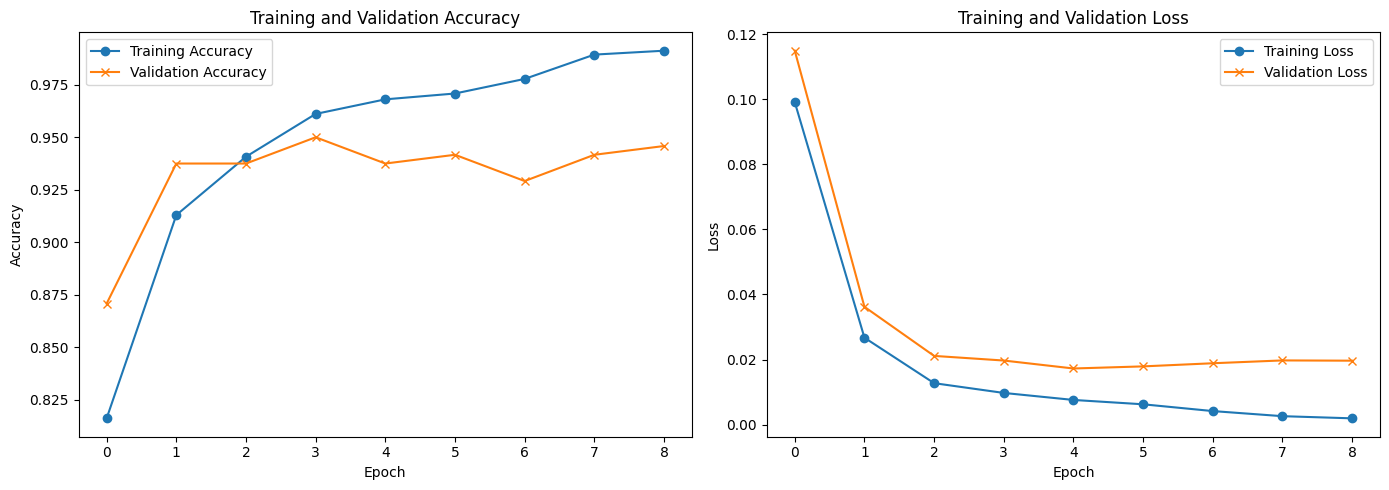

In [40]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy', marker='o')
    plt.plot(val_acc, label='Validation Accuracy', marker='x')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss', marker='o')
    plt.plot(val_loss, label='Validation Loss', marker='x')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_training_history(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
Classification Report:

              precision    recall  f1-score   support

      Female       0.87      0.99      0.93        94
        Male       0.99      0.90      0.95       146

    accuracy                           0.94       240
   macro avg       0.93      0.95      0.94       240
weighted avg       0.94      0.94      0.94       240

F1 Score     : 0.9462
Precision    : 0.9925
Recall       : 0.9041


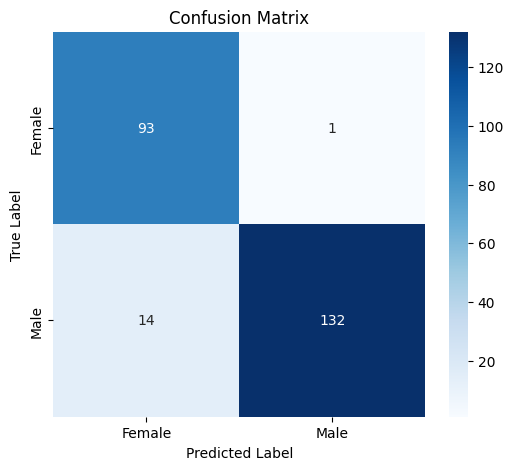

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns
import numpy as np

def evaluate_model(model, val_dataset):
    # Get true labels and predictions
    y_true = []
    y_pred = []

    for images, labels in val_dataset:
        preds = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend((preds > 0.5).astype(int).flatten())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Metrics
    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    print("Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=['Female', 'Male'], zero_division=0))

    print(f"F1 Score     : {f1:.4f}")
    print(f"Precision    : {precision:.4f}")
    print(f"Recall       : {recall:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Usage
evaluate_model(model, val_ds)